In [2]:
%matplotlib inline

import time
import sys
import os

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# ML methods
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Raw data

In [3]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Cleaning & Enriching


## Raw features

* shot_distance
* loc_x/y: Where on the court. Strong correlation with shot_distance,
* shot_zone_range: Redundant, categorical version of shot_distance
* shot_type: Seems only field goals are included, no penalty shots? Redundant, information is in shot_distance
* shot_zone_area: Rendant, informatino is in loc_x/loc_y
* opponent: Categorical. Approx 20 values
* combined_shot_type: Some correlation with shot_distance. Eg: Dunk always very close, Jump shots mostly far away
* minutes/seconds_remaining: In the period 
* period: Categorical
* season: Related to time (of career). 
* playoffs: 1/0. Different kind of game


In [4]:
preprocessed = raw.copy()

# MAYBE: Remove rare super longshots. But only for training, exists in compete set
# raw = raw[raw['shot_distance'] < 30.0]

# Tools

In [34]:
# Poor-mans GridSearchCV
def grid_search(estimator, grid, X, Y, splits=100, test_size=0.3, print_progress=True):
    pp = ParameterGrid(grid)
    
    results = []
    
    if print_progress:
        print('%d models with %d splits' % (len(pp), splits))
    
    # Calculate the best hyperparameters
    for model_idx, parameters in enumerate(pp):

        training_accuracies = []
        testing_accuracies = []
        for seed in range(0, splits):
            start_time = time.time()
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
            
            model = estimator(**parameters)
            model.fit(X_train, Y_train)
            
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            train_score = sklearn.metrics.accuracy_score(Y_train, Y_train_pred) 
            test_score = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
            
            training_accuracies.append(train_score)
            testing_accuracies.append(test_score)
            end_time = time.time()
            if seed == 0:
                sys.stdout.write('\n %d/%d: %.2f(s) ' % (model_idx, len(pp), end_time-start_time))
            else:
                sys.stdout.write('.')
        
        # TODO: also return variance
        result = {
            'training_accuracy': numpy.average(training_accuracies),
            'testing_accuracy': numpy.average(testing_accuracies),
            'parameters': parameters,
        }
        results.append(result)

    # Select best result and retrain model on whole dataset
    by_accuracy = sorted(results, key=lambda r: r['testing_accuracy'], reverse=True)
    best_idx = results.index(by_accuracy[0])
    best_parameters = by_accuracy[0]['parameters']
    model = estimator(**best_parameters)
    model.fit(X, Y)
            
    return model, results, best_idx

## Model

In [28]:
def get_distance_class(bins, group):
    distance = group['shot_distance']
    distance_class = len(bins)
    for idx, edge in enumerate(bins[1:]):
        if distance < edge:
            distance_class = idx
            break
    #print('d', distance, distance_class)\n",
    return distance_class

In [27]:
def linear_svc(**params):
    # C=1.0, penalty='l2'
    params['dual'] = False # 10x faster
    return LinearSVC(**params)

def random_forest(**params):
    # n_estimators=10, max_depth=None, max_features=’auto’, min_samples_split
    return RandomForestClassifier(**params)

def logit(**params):
     # C=1.0, penalty=’l2’ 
    return LogisticRegression(**params)

def radial_svc(**params):
    # C=1.0, gamma=’auto’
    params['kernel'] = 'rbf'
    return SVC(**params)

def kNN(**params):
    # p=2, n_neighbors=5
    return KNeighborsClassifier(**params)


alternatives = {
    'random_forest': {
        'n_estimators': [ 4, 16, 32 ],
        'min_samples_split': [ 0.01, 0.05, 0.1, 0.2 ],
    },
    'logit': {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0 ],
    },
    'kNN': {
        'n_neighbors': [ 5, 10, 15 ],
        'p': [ 2 ],
    },
    'linear_svc': {
        'C': [ 0.005, 0.01, 0.02, 0.05, ],
        'tol': [ 0.000001, 0.00001, ],
        #'penalty': ['l2', 'l1'],
    },
    'radial_svc': {
        'C': [ 0.01, 0.05, 0.1, 0.2 ],
    }
}

In [58]:
class FeatureEncoder():

    def __init__(self, dist_bins):
        self.dist_bins = dist_bins
        b = list(range(len(dist_bins)+1))
        print(b)
        self.dist_dtype = pandas.api.types.CategoricalDtype(categories=b, ordered=True)
        
    def transform(self, data):
        period_mins = 12
        period_time = (data['minutes_remaining'] * 60) + (data['seconds_remaining'])
        game_time = (data['period']*period_mins*60)

        distance_class = data.apply(lambda g: get_distance_class(self.dist_bins, g), axis=1) 
        print('d', sorted(distance_class.unique()))
        shot_distance_squared = data['shot_distance'] * data['shot_distance']
        # could calculate angle from loc_x/y. Less redundancy with shot_distance?
        # could try a better shot_distance estimator
        # could bring back distance_class
        # could have left_court / right_court (/middle_court) based on loc_x or angle
        # could create feature crosses:
        #  shot_type X distance_class
        #  Opponent X distance_class ?
        #  Opponent X loc_x/angle
        #  (binned) loc_y X loc_bin_x
        #  
        
        features = pandas.DataFrame({
            'shot_type': data['combined_shot_type'].astype('category'),
            'season': data['season'].astype('category'),
            'opponent': data['opponent'].astype('category'),
            'playoffs': data['playoffs'].astype('category'),

            'game_time': game_time,
            'period_time': period_time,
            'period': data['period'].astype('category'),
            
            'points': data['shot_type'].astype('category'),
            #'loc_x': data['loc_x'], 
            #'shot_distance': data['shot_distance'],            
            #'shot_distance_squared': shot_distance_squared,
            'distance_class': distance_class.astype(self.dist_dtype),
        })

        scaled = set([
            'game_time', 'period_time', 'loc_x',
            'shot_distance', 'shot_distance_squared'
        ]).intersection(features.columns)
        if len(scaled):
            features[list(scaled)] = StandardScaler().fit_transform(features[list(scaled)])
        
        categorical = set(['shot_type', 'period', 'season', 'opponent', 'points', 'distance_class'])
        cat_columns = set(features.columns).intersection(categorical)
        
        encoded = pandas.get_dummies(features, columns=list(cat_columns), drop_first=True)
        return encoded
    

q, dist_bins = pandas.qcut(preprocessed['shot_distance'], q=10, duplicates='drop', retbins=True)
encoder = FeatureEncoder(dist_bins)
usage_set = preprocessed[preprocessed['shot_made_flag'].notnull()]

encoded = encoder.transform(usage_set)
X = encoded
Y = usage_set['shot_made_flag'].astype(numpy.bool)
    
#encoded.shape
m = 'random_forest'
best_model, r, best_idx = grid_search(locals()[m], alternatives[m], X, Y, splits=5)

r[best_idx]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
12 models with 5 splits

 0/12: 0.58(s) ....
 1/12: 1.43(s) ....
 2/12: 2.40(s) ....
 3/12: 0.48(s) ....
 4/12: 0.97(s) ....
 5/12: 1.85(s) ....
 6/12: 0.45(s) ....
 7/12: 0.84(s) ....
 8/12: 1.39(s) ....
 9/12: 0.43(s) ....
 10/12: 0.72(s) ....
 11/12: 1.17(s) ....

{'parameters': {'min_samples_split': 0.2, 'n_estimators': 16},
 'testing_accuracy': 0.6136553945249598,
 'training_accuracy': 0.613184234140954}

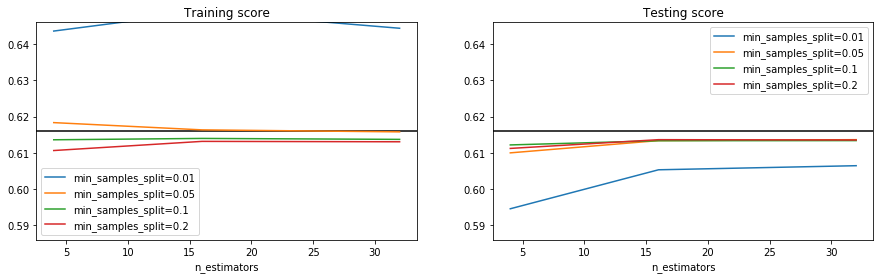

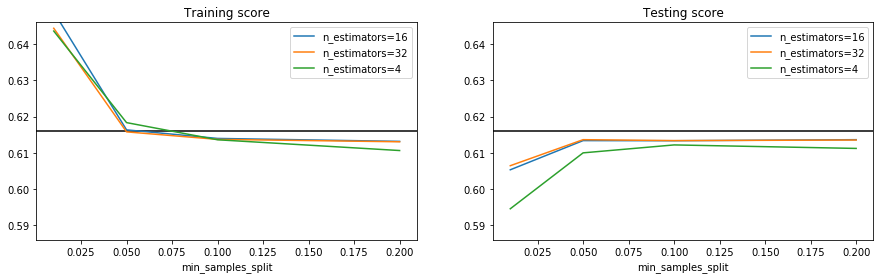

In [59]:
def plot_results(res):
    training = map(lambda r: r['training_accuracy'], res)
    testing = map(lambda r: r['testing_accuracy'], res)
    
    param_names = res[0]['parameters'].keys()
    series = {}
    for name in param_names:
        values = list(map(lambda r: repr(r['parameters'][name]), res))
        series[name] = values
    
    # TODO: plot variance
    # TODO: plot heatmap
    
    series['training_score'] = list(training)
    series['testing_score'] = list(testing)
    
    df = pandas.DataFrame(series)
    #print(df)
    
    # .plot(figsize=(4,4), sharex=True, sharey=True)
    
    target = 0.616
    spread = 0.03
    # multiline plot with group by 
    def plot_score_trend(group_key, x_key):
        fig, (train_ax, test_ax) = plt.subplots(1, 2, figsize=(15, 4))
        train_ax.set_title("Training score")
        test_ax.set_title("Testing score")
        train_ax.set_xlabel(x_key)
        test_ax.set_xlabel(x_key)
        train_ax.set_ylim(target-spread, target+spread)
        test_ax.set_ylim(target-spread, target+spread)
        test_ax.axhline(y=target, color='black')
        train_ax.axhline(y=target, color='black')
        
        for val, group in df.groupby(group_key):
            label = '{}={}'.format(group_key, val)
            x = [ float(x) for x in group[x_key] ]
            train_ax.plot(list(x), list(group['training_score']), label=label)
            test_ax.plot(list(x), list(group['testing_score']), label=label)

        train_ax.legend()
        test_ax.legend()
        return fig

    first, second = param_names
    fig1 = plot_score_trend(first, second)
    fig2 = plot_score_trend(second, first)

    return fig1, fig2

plot_results(r);

Feature ranking:
1. 3 : shot_type_Dunk (0.338045)
2. 5 : shot_type_Jump Shot (0.298196)
3. 37 : points_3PT Field Goal (0.137141)
4. 6 : shot_type_Layup (0.094421)
5. 34 : distance_class_8 (0.033856)
6. 1 : period_time (0.025069)
7. 0 : game_time (0.009107)
8. 40 : period_4 (0.007869)
9. 30 : distance_class_4 (0.007085)
10. 32 : distance_class_6 (0.005769)
11. 31 : distance_class_5 (0.004158)
12. 28 : distance_class_2 (0.003637)
13. 29 : distance_class_3 (0.003459)
14. 68 : opponent_POR (0.003166)
15. 58 : opponent_MIL (0.002787)
16. 50 : opponent_DEN (0.002434)
17. 33 : distance_class_7 (0.002348)
18. 22 : season_2011-12 (0.001541)
19. 8 : season_1997-98 (0.001253)
20. 20 : season_2009-10 (0.001248)
21. 26 : season_2015-16 (0.001209)
22. 47 : opponent_CHI (0.001090)
23. 21 : season_2010-11 (0.001082)
24. 67 : opponent_PHX (0.001004)
25. 25 : season_2014-15 (0.000910)
26. 7 : shot_type_Tip Shot (0.000872)
27. 16 : season_2005-06 (0.000850)
28. 61 : opponent_NOH (0.000723)
29. 27 : dista

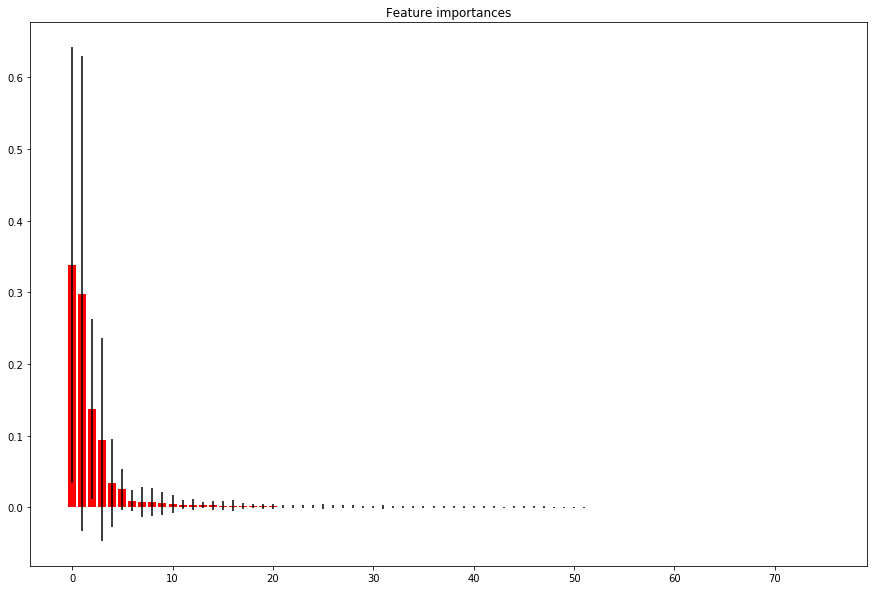

In [60]:
import numpy as np

def plot_forest_importance(forest):

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

plot_forest_importance(best_model);


In [62]:
def make_submission(model, data):
    assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
    assert compete_set['shot_id'].values[0] == 4
    assert compete_set['shot_id'].values[-1] == 30693
    
    Y_comp = model.predict(data)
    
    out = compete_set.copy()
    out['shot_made_flag'] = Y_comp.astype(numpy.float)
    out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

compete_set = preprocessed[pandas.isna(preprocessed['shot_made_flag'])]
X_submit = encoder.transform(compete_set)
make_submission(best_model, X_submit)
#set(X_submit.columns).difference(X.columns), set(X.columns).difference(X_submit.columns)

d [0, 1, 2, 3, 4, 5, 6, 7, 8]


# Data exploration

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR ?


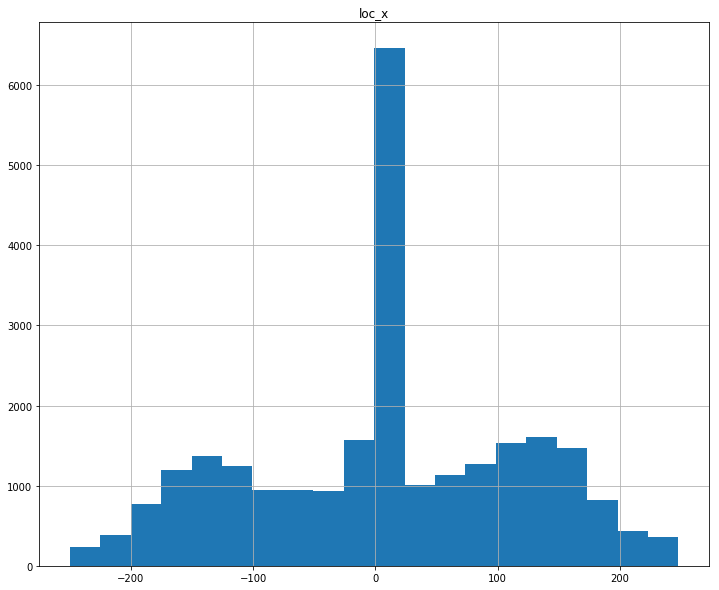

In [155]:
preprocessed.hist(column='loc_x', bins=20, figsize=(12,10), sharey=True);

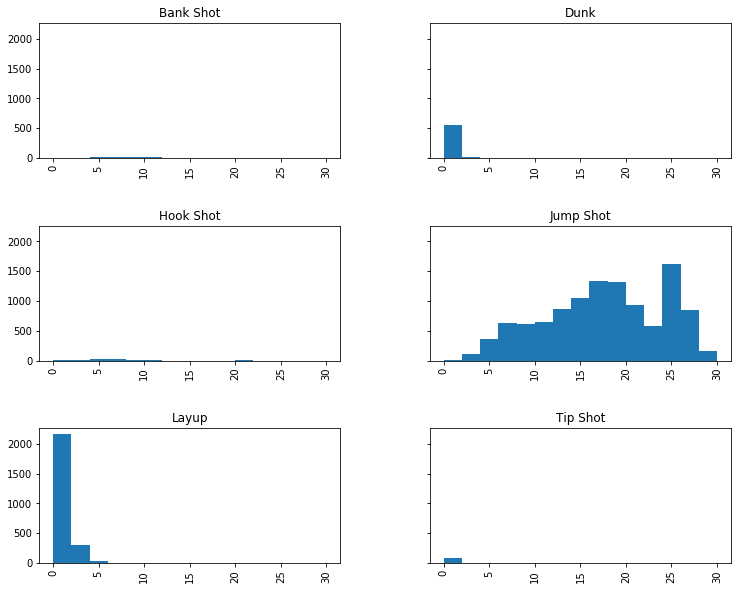

In [167]:
training.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

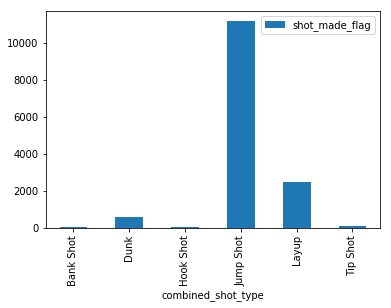

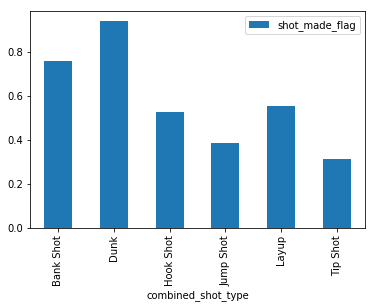

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

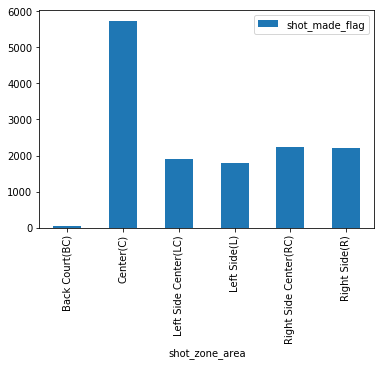

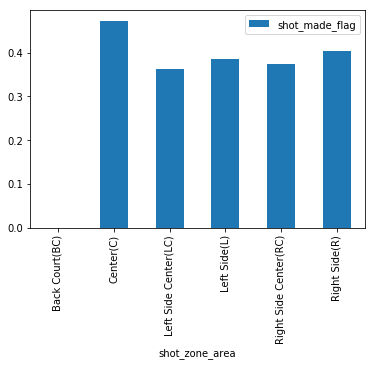

In [173]:
shot_zone = training[training['combined_shot_type'] != 'Dunk'].groupby(['shot_zone_area'])
shot_zone.agg({'shot_made_flag': 'count'}).plot(kind='bar')
shot_zone.agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [150]:
shot_area_type = training.groupby(['shot_zone_area', 'combined_shot_type'])
shot_area_type.agg({'shot_made_flag': 'mean'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')

NameError: name 'training' is not defined

In [174]:
training['season'].unique()

array(['2004-05', '1997-98', '2006-07', '2012-13', '2003-04', '2005-06',
       '2000-01', '2009-10', '2002-03', '2007-08', '2015-16', '2010-11',
       '1998-99', '2001-02', '1999-00', '2013-14', '2008-09', '2011-12',
       '1996-97', '2014-15'], dtype=object)

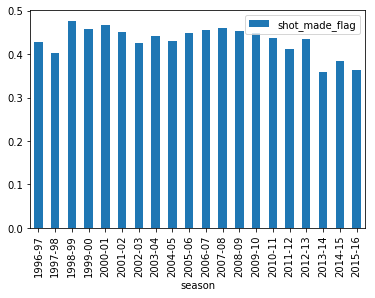

In [175]:
training.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [11]:
training['opponent'].unique()

array(['DET', 'DAL', 'HOU', 'LAC', 'SAC', 'CHA', 'GSW', 'UTA', 'MIL',
       'IND', 'POR', 'NYK', 'NOH', 'VAN', 'NOP', 'MEM', 'OKC', 'MIN',
       'ORL', 'NJN', 'DEN', 'CLE', 'MIA', 'SEA', 'CHI', 'SAS', 'BOS',
       'PHX', 'WAS', 'TOR', 'PHI', 'ATL', 'BKN'], dtype=object)

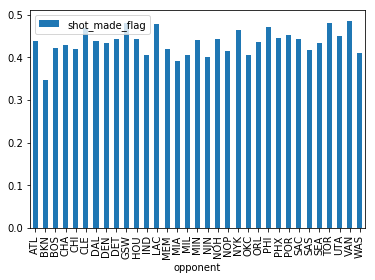

In [30]:
training.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

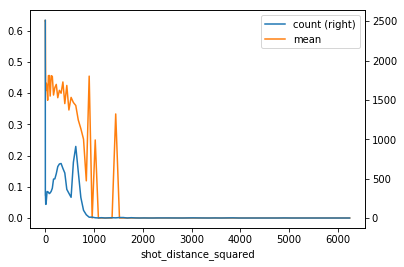

In [202]:
type_by_distance = training[training['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance_squared'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

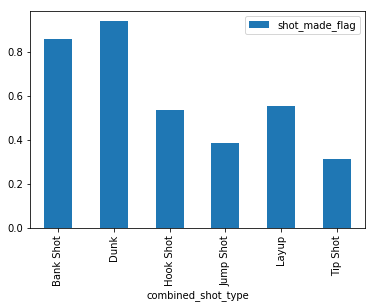

In [95]:
training[training['shot_distance'] < 5.0].groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

d [ 0.  2.  7. 12. 15. 17. 19. 23. 25. 79.]
e 0 2.0
e 10 2.0
e 10 7.0
e 10 12.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 0 2.0
e 0 2.0
e 25 2.0
e 25 7.0
e 25 12.0
e 25 15.0
e 25 17.0
e 25 19.0
e 25 23.0
e 25 25.0
e 25 79.0
e 3 2.0
e 3 7.0
e 17 2.0
e 17 7.0
e 17 12.0
e 17 15.0
e 17 17.0
e 17 19.0
e 0 2.0


,shot_distance,distance_class
5862,0,0
20287,10,2
9367,26,8
16878,26,8
4486,0,0
9591,0,0
7325,25,8
9019,3,1
688,17,5
13191,0,0


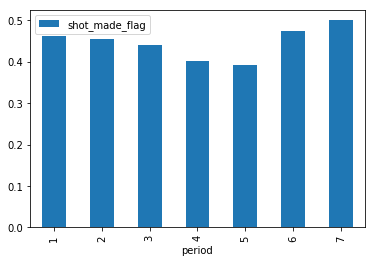

In [251]:
training.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')